In [1]:
%matplotlib inline

# Radial velocity fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.2.0


In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

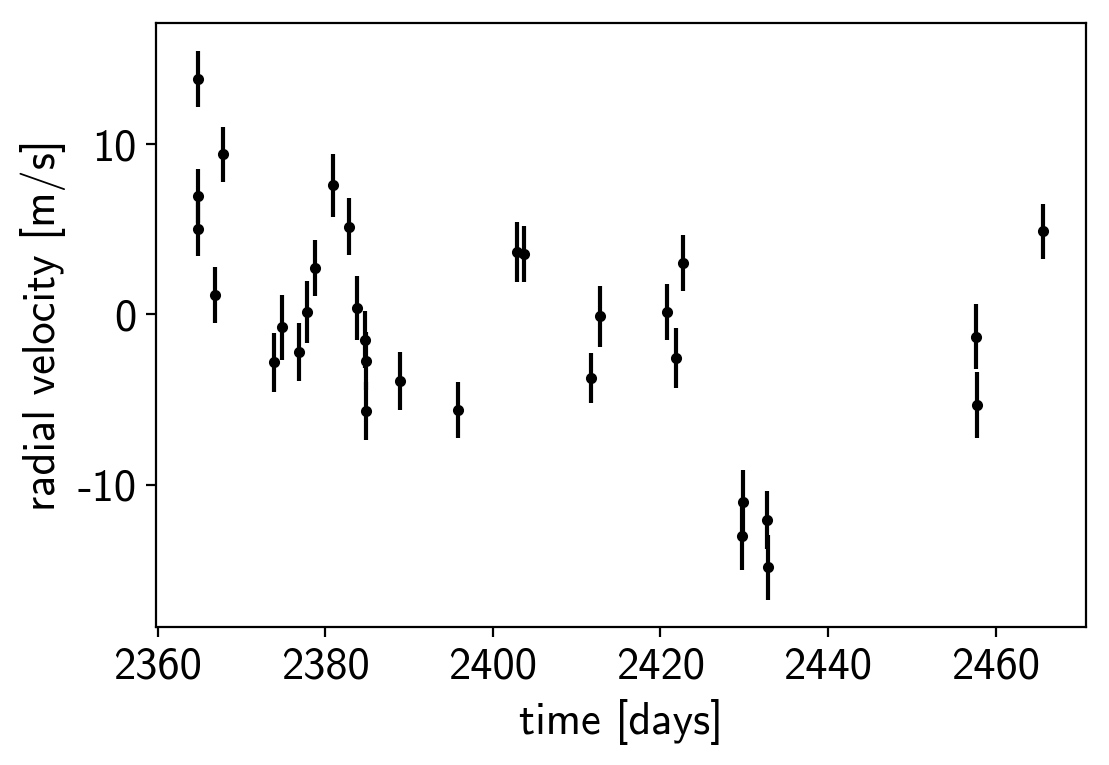

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Normal("P", mu=np.array(periods), sd=np.array(period_errs), shape=2)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=10.0, shape=2)
    
    # This is a sanity check that restricts the semiamplitude to reasonable
    # values because things can get ugly as K -> 0
    pm.Potential("logK_bound", tt.switch(logK < 0, -np.inf, 0.0))
    
    # We also want to keep period physical but this probably won't be hit
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Eccentricity & argument of periasteron
    ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, shape=2,
                  testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2)
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     tt.sum(vrad_pred, axis=-1) + bkg_pred)

Now, we can plot the initial model:

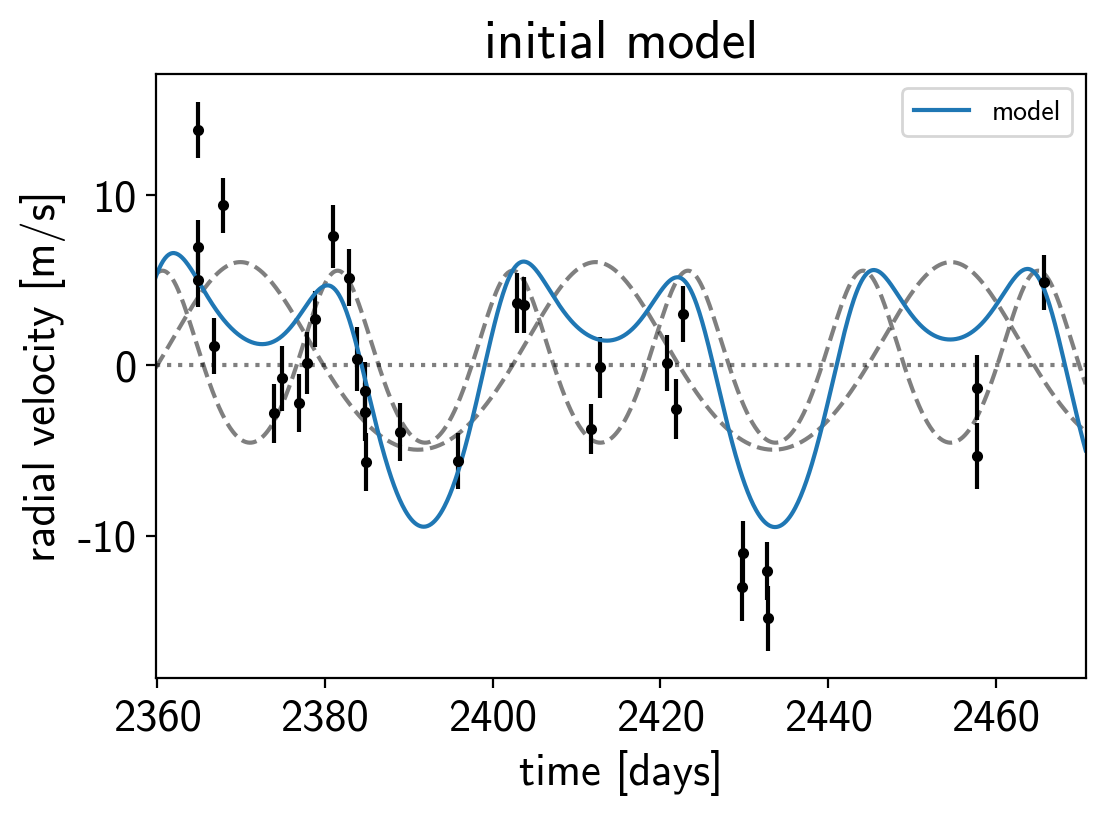

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -85.64878196427784 -> -70.76432173140468


optimizing logp for variables: ['trend', 'logs', 'omega_angle__', 'ecc_logodds__', 'logK', 'P', 't0']


message: Optimization terminated successfully.
logp: -70.76432173140468 -> -21.515004321663945


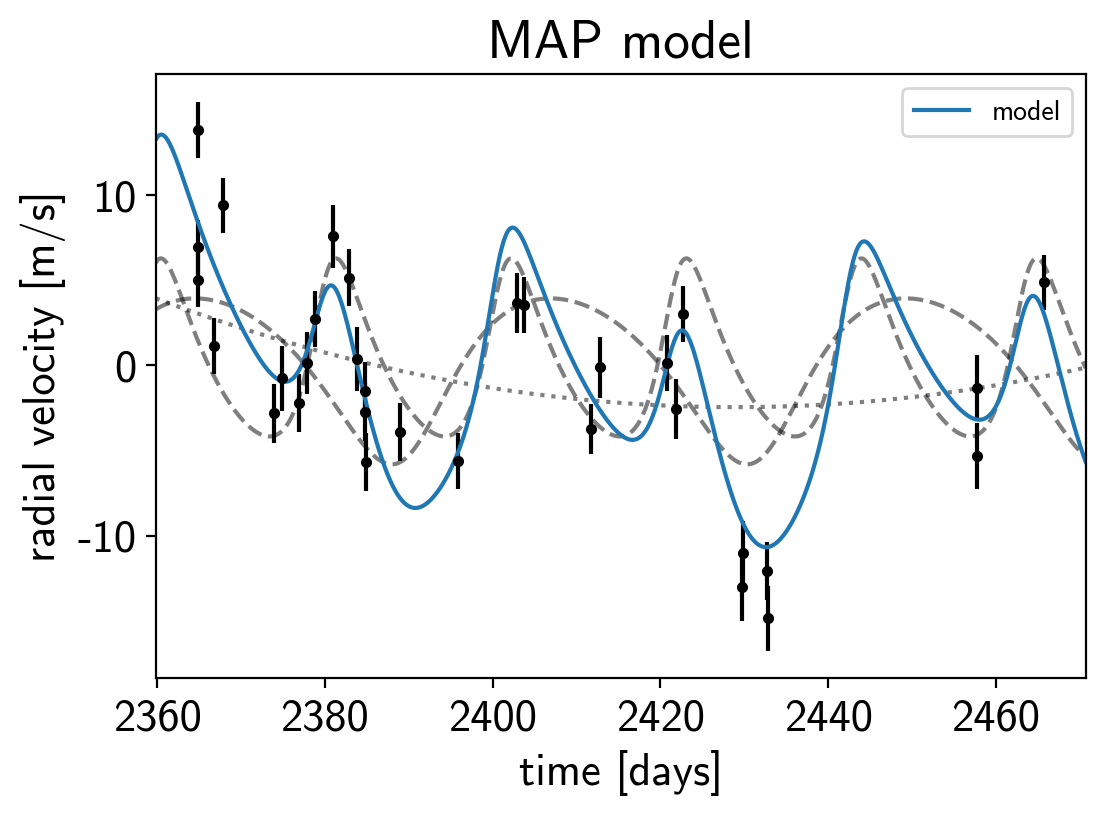

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :class:`exoplanet.PyMC3Sampler` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:04, 189.87draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:00<00:06, 122.29draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:00<00:07, 103.26draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:00<00:08, 94.59draws/s] 

Sampling 4 chains:   6%|▋         | 52/808 [00:00<00:08, 89.38draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:00<00:08, 86.07draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:00<00:08, 86.94draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:00<00:08, 84.47draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:00<00:08, 82.78draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:01<00:08, 80.50draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:01<00:09, 78.36draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:01<00:09, 76.93draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:01<00:09, 76.67draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:01<00:08, 77.05draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:01<00:08, 80.13draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:01<00:08, 82.50draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:01<00:07, 84.12draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:01<00:07, 81.69draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:01<00:07, 83.32draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:02<00:06, 98.06draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:02<00:06, 100.29draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:02<00:06, 90.15draws/s] 

Sampling 4 chains:  27%|██▋       | 219/808 [00:02<00:06, 85.56draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:02<00:06, 84.16draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:02<00:07, 80.59draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:02<00:07, 76.57draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:02<00:07, 77.40draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:03<00:06, 78.00draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:03<00:06, 77.92draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:03<00:06, 78.50draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:03<00:06, 78.83draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:03<00:06, 79.07draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:03<00:06, 81.99draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:03<00:05, 84.20draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:03<00:05, 85.15draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:03<00:05, 84.04draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:03<00:05, 87.74draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:04<00:05, 84.12draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:04<00:05, 81.97draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:04<00:05, 83.14draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:04<00:05, 83.15draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:04<00:05, 81.22draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:04<00:04, 83.17draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:04<00:04, 83.50draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:04<00:04, 84.89draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [00:04<00:04, 82.24draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:05<00:04, 84.29draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:05<00:04, 88.32draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [00:05<00:04, 88.69draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:05<00:04, 82.85draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:05<00:04, 81.92draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:05<00:04, 81.07draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:05<00:04, 79.98draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:05<00:04, 76.44draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:05<00:03, 76.67draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:06<00:03, 82.23draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:06<00:03, 82.76draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:06<00:03, 78.76draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:06<00:03, 79.61draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:06<00:03, 80.96draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:06<00:03, 77.97draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [00:06<00:03, 78.06draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:06<00:02, 80.87draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:06<00:02, 82.93draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [00:07<00:02, 84.46draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:07<00:02, 85.54draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:07<00:02, 81.95draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:07<00:02, 79.14draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [00:07<00:02, 79.20draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:07<00:02, 78.99draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:07<00:02, 78.86draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [00:07<00:01, 78.81draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [00:07<00:01, 78.53draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:08<00:01, 78.18draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:08<00:01, 78.23draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:08<00:01, 79.65draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:08<00:01, 78.38draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:08<00:01, 78.45draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:08<00:01, 78.63draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [00:08<00:01, 76.68draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:08<00:01, 77.10draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:08<00:00, 77.41draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:08<00:00, 77.23draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [00:09<00:00, 79.95draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:09<00:00, 81.52draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:09<00:00, 80.50draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:09<00:00, 74.40draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:09<00:00, 75.60draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:09<00:00, 79.05draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:10<00:00, 44.64draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:10<00:00, 78.53draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▍         | 19/408 [00:00<00:02, 183.46draws/s]

Sampling 4 chains:   7%|▋         | 27/408 [00:00<00:02, 130.92draws/s]

Sampling 4 chains:   9%|▊         | 35/408 [00:00<00:03, 105.95draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:00<00:03, 109.94draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:00<00:03, 105.53draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:00<00:03, 102.62draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:00<00:03, 100.82draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:00<00:03, 95.57draws/s] 

Sampling 4 chains:  25%|██▍       | 101/408 [00:00<00:03, 91.45draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:01<00:03, 91.32draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:01<00:03, 85.13draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:01<00:03, 84.66draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:01<00:03, 88.14draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:01<00:03, 82.92draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:01<00:02, 84.32draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:01<00:02, 85.17draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:01<00:02, 83.81draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:02<00:02, 93.17draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:02<00:02, 93.18draws/s]

Sampling 4 chains:  52%|█████▏    | 211/408 [00:02<00:02, 92.45draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:02<00:02, 93.07draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:02<00:01, 94.36draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:02<00:01, 94.59draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [00:02<00:01, 88.30draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:02<00:01, 88.34draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:02<00:01, 86.81draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:02<00:01, 86.34draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:03<00:01, 86.51draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:03<00:01, 86.01draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:03<00:01, 84.93draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:03<00:01, 79.02draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [00:03<00:01, 79.17draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:03<00:00, 83.28draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:03<00:00, 80.58draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:03<00:00, 90.52draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:04<00:00, 84.81draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:04<00:00, 85.25draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:04<00:00, 86.80draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [00:04<00:00, 78.44draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:04<00:00, 55.85draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:04<00:00, 36.42draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:03, 202.38draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:00<00:05, 149.28draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:00<00:05, 148.96draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:00<00:04, 160.09draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:00<00:04, 148.62draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:00<00:04, 157.90draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:00<00:04, 160.81draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:00<00:03, 183.40draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:00<00:03, 184.06draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:01<00:03, 191.03draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:01<00:02, 202.82draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:01<00:02, 196.30draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:01<00:02, 193.66draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:01<00:02, 185.68draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:01<00:02, 201.01draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:01<00:02, 224.13draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:01<00:01, 231.60draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:01<00:01, 225.73draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:02<00:01, 214.55draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:02<00:01, 214.98draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:02<00:01, 208.62draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:02<00:01, 206.93draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [00:02<00:01, 186.28draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [00:02<00:01, 186.13draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:02<00:01, 176.73draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:02<00:01, 185.15draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:02<00:01, 188.47draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:03<00:01, 202.49draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [00:03<00:00, 216.19draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [00:03<00:00, 227.24draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:03<00:00, 237.85draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:03<00:00, 226.90draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [00:03<00:00, 214.04draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [00:03<00:00, 201.02draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:03<00:00, 217.15draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:04<00:00, 139.13draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:04<00:00, 188.42draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:00<00:04, 333.63draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:00<00:04, 354.51draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:00<00:03, 382.99draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:00<00:03, 396.80draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:00<00:03, 408.32draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:00<00:03, 387.90draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [00:00<00:03, 390.36draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [00:00<00:03, 408.88draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [00:00<00:03, 401.76draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [00:01<00:03, 371.82draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [00:01<00:02, 389.25draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [00:01<00:02, 376.79draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [00:01<00:02, 389.42draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [00:01<00:02, 414.90draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [00:01<00:02, 437.73draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [00:01<00:02, 445.81draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [00:01<00:01, 458.83draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [00:01<00:01, 449.55draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [00:01<00:01, 442.62draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [00:02<00:01, 450.42draws/s]

Sampling 4 chains:  57%|█████▋    | 923/1608 [00:02<00:01, 441.87draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [00:02<00:01, 447.05draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [00:02<00:01, 445.70draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [00:02<00:01, 448.98draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [00:02<00:01, 456.18draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [00:02<00:01, 442.33draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [00:02<00:00, 441.70draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [00:02<00:00, 423.15draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [00:03<00:00, 423.86draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [00:03<00:00, 416.17draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [00:03<00:00, 377.57draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [00:03<00:00, 362.48draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [00:03<00:00, 322.31draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [00:03<00:00, 310.85draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [00:03<00:00, 296.19draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [00:03<00:00, 270.39draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [00:04<00:00, 269.37draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [00:04<00:00, 205.87draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:04<00:00, 376.37draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:00<00:07, 445.87draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:00<00:06, 460.07draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:00<00:06, 495.39draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:00<00:06, 465.84draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [00:00<00:06, 457.35draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:00<00:06, 452.99draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [00:00<00:06, 448.43draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [00:00<00:06, 425.34draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [00:00<00:06, 431.12draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [00:01<00:06, 436.02draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [00:01<00:06, 441.40draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [00:01<00:05, 443.69draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [00:01<00:05, 466.15draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [00:01<00:05, 482.74draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [00:01<00:05, 486.98draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [00:01<00:05, 486.39draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [00:01<00:04, 505.12draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [00:01<00:04, 512.03draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [00:01<00:04, 510.16draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [00:02<00:04, 528.73draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [00:02<00:04, 506.49draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [00:02<00:04, 496.17draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [00:02<00:04, 507.25draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [00:02<00:03, 510.50draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [00:02<00:03, 508.23draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [00:02<00:03, 512.79draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [00:02<00:03, 514.14draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [00:02<00:03, 534.87draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [00:02<00:03, 545.37draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [00:03<00:03, 495.72draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [00:03<00:03, 477.12draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [00:03<00:03, 489.19draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [00:03<00:02, 509.95draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [00:03<00:02, 540.78draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [00:03<00:02, 554.89draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [00:03<00:02, 568.29draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [00:03<00:02, 569.03draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [00:03<00:02, 547.43draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [00:04<00:02, 532.61draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [00:04<00:01, 554.82draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [00:04<00:01, 551.97draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [00:04<00:01, 556.63draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [00:04<00:01, 569.12draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [00:04<00:01, 553.11draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [00:04<00:01, 548.80draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [00:04<00:01, 544.78draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [00:04<00:01, 525.66draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [00:04<00:01, 520.66draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [00:05<00:01, 512.77draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [00:05<00:01, 519.44draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [00:05<00:00, 529.41draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [00:05<00:00, 539.46draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [00:05<00:00, 547.29draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [00:05<00:00, 549.08draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [00:05<00:00, 550.58draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [00:05<00:00, 551.44draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [00:05<00:00, 531.19draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [00:06<00:00, 533.83draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [00:06<00:00, 524.02draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:06<00:00, 504.59draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 36/9208 [00:00<00:25, 357.54draws/s]

Sampling 4 chains:   1%|          | 90/9208 [00:00<00:23, 396.30draws/s]

Sampling 4 chains:   1%|▏         | 136/9208 [00:00<00:21, 412.66draws/s]

Sampling 4 chains:   2%|▏         | 180/9208 [00:00<00:21, 419.75draws/s]

Sampling 4 chains:   2%|▏         | 226/9208 [00:00<00:20, 430.81draws/s]

Sampling 4 chains:   3%|▎         | 281/9208 [00:00<00:19, 460.56draws/s]

Sampling 4 chains:   4%|▎         | 333/9208 [00:00<00:18, 476.84draws/s]

Sampling 4 chains:   4%|▍         | 379/9208 [00:00<00:18, 471.64draws/s]

Sampling 4 chains:   5%|▍         | 425/9208 [00:00<00:18, 466.89draws/s]

Sampling 4 chains:   5%|▌         | 483/9208 [00:01<00:17, 493.73draws/s]

Sampling 4 chains:   6%|▌         | 533/9208 [00:01<00:17, 483.70draws/s]

Sampling 4 chains:   6%|▋         | 582/9208 [00:01<00:18, 464.99draws/s]

Sampling 4 chains:   7%|▋         | 641/9208 [00:01<00:17, 496.20draws/s]

Sampling 4 chains:   8%|▊         | 701/9208 [00:01<00:16, 521.19draws/s]

Sampling 4 chains:   8%|▊         | 765/9208 [00:01<00:15, 551.89draws/s]

Sampling 4 chains:   9%|▉         | 822/9208 [00:01<00:15, 545.70draws/s]

Sampling 4 chains:  10%|▉         | 879/9208 [00:01<00:15, 547.03draws/s]

Sampling 4 chains:  10%|█         | 935/9208 [00:01<00:15, 535.51draws/s]

Sampling 4 chains:  11%|█         | 992/9208 [00:01<00:15, 544.88draws/s]

Sampling 4 chains:  11%|█▏        | 1047/9208 [00:02<00:14, 544.92draws/s]

Sampling 4 chains:  12%|█▏        | 1102/9208 [00:02<00:15, 536.03draws/s]

Sampling 4 chains:  13%|█▎        | 1158/9208 [00:02<00:14, 541.78draws/s]

Sampling 4 chains:  13%|█▎        | 1213/9208 [00:02<00:15, 530.51draws/s]

Sampling 4 chains:  14%|█▍        | 1267/9208 [00:02<00:15, 525.74draws/s]

Sampling 4 chains:  14%|█▍        | 1320/9208 [00:02<00:15, 497.17draws/s]

Sampling 4 chains:  15%|█▍        | 1371/9208 [00:02<00:16, 468.36draws/s]

Sampling 4 chains:  15%|█▌        | 1419/9208 [00:02<00:17, 454.11draws/s]

Sampling 4 chains:  16%|█▌        | 1473/9208 [00:02<00:16, 475.81draws/s]

Sampling 4 chains:  17%|█▋        | 1526/9208 [00:03<00:15, 490.29draws/s]

Sampling 4 chains:  17%|█▋        | 1576/9208 [00:03<00:15, 484.96draws/s]

Sampling 4 chains:  18%|█▊        | 1625/9208 [00:03<00:16, 463.89draws/s]

Sampling 4 chains:  18%|█▊        | 1679/9208 [00:03<00:15, 483.46draws/s]

Sampling 4 chains:  19%|█▉        | 1728/9208 [00:03<00:15, 481.73draws/s]

Sampling 4 chains:  19%|█▉        | 1784/9208 [00:03<00:14, 501.11draws/s]

Sampling 4 chains:  20%|█▉        | 1835/9208 [00:03<00:14, 499.68draws/s]

Sampling 4 chains:  21%|██        | 1894/9208 [00:03<00:14, 522.15draws/s]

Sampling 4 chains:  21%|██        | 1947/9208 [00:03<00:13, 521.72draws/s]

Sampling 4 chains:  22%|██▏       | 2000/9208 [00:03<00:14, 510.70draws/s]

Sampling 4 chains:  22%|██▏       | 2052/9208 [00:04<00:14, 506.79draws/s]

Sampling 4 chains:  23%|██▎       | 2104/9208 [00:04<00:13, 509.41draws/s]

Sampling 4 chains:  23%|██▎       | 2157/9208 [00:04<00:13, 510.81draws/s]

Sampling 4 chains:  24%|██▍       | 2209/9208 [00:04<00:13, 510.87draws/s]

Sampling 4 chains:  25%|██▍       | 2261/9208 [00:04<00:14, 495.49draws/s]

Sampling 4 chains:  25%|██▌       | 2315/9208 [00:04<00:13, 504.47draws/s]

Sampling 4 chains:  26%|██▌       | 2367/9208 [00:04<00:13, 507.63draws/s]

Sampling 4 chains:  26%|██▋       | 2419/9208 [00:04<00:13, 509.99draws/s]

Sampling 4 chains:  27%|██▋       | 2473/9208 [00:04<00:13, 515.97draws/s]

Sampling 4 chains:  27%|██▋       | 2526/9208 [00:05<00:12, 518.84draws/s]

Sampling 4 chains:  28%|██▊       | 2578/9208 [00:05<00:12, 511.54draws/s]

Sampling 4 chains:  29%|██▊       | 2630/9208 [00:05<00:12, 512.96draws/s]

Sampling 4 chains:  29%|██▉       | 2682/9208 [00:05<00:12, 514.10draws/s]

Sampling 4 chains:  30%|██▉       | 2735/9208 [00:05<00:12, 518.27draws/s]

Sampling 4 chains:  30%|███       | 2795/9208 [00:05<00:11, 540.20draws/s]

Sampling 4 chains:  31%|███       | 2851/9208 [00:05<00:11, 545.79draws/s]

Sampling 4 chains:  32%|███▏      | 2906/9208 [00:05<00:11, 540.45draws/s]

Sampling 4 chains:  32%|███▏      | 2961/9208 [00:05<00:11, 538.64draws/s]

Sampling 4 chains:  33%|███▎      | 3019/9208 [00:05<00:11, 548.80draws/s]

Sampling 4 chains:  33%|███▎      | 3083/9208 [00:06<00:10, 571.32draws/s]

Sampling 4 chains:  34%|███▍      | 3141/9208 [00:06<00:10, 568.76draws/s]

Sampling 4 chains:  35%|███▍      | 3199/9208 [00:06<00:11, 532.23draws/s]

Sampling 4 chains:  35%|███▌      | 3253/9208 [00:06<00:11, 511.92draws/s]

Sampling 4 chains:  36%|███▌      | 3305/9208 [00:06<00:11, 510.02draws/s]

Sampling 4 chains:  37%|███▋      | 3363/9208 [00:06<00:11, 528.12draws/s]

Sampling 4 chains:  37%|███▋      | 3419/9208 [00:06<00:10, 534.74draws/s]

Sampling 4 chains:  38%|███▊      | 3476/9208 [00:06<00:10, 543.06draws/s]

Sampling 4 chains:  38%|███▊      | 3534/9208 [00:06<00:10, 553.13draws/s]

Sampling 4 chains:  39%|███▉      | 3591/9208 [00:06<00:10, 554.70draws/s]

Sampling 4 chains:  40%|███▉      | 3648/9208 [00:07<00:09, 558.21draws/s]

Sampling 4 chains:  40%|████      | 3704/9208 [00:07<00:10, 547.37draws/s]

Sampling 4 chains:  41%|████      | 3759/9208 [00:07<00:10, 538.74draws/s]

Sampling 4 chains:  41%|████▏     | 3813/9208 [00:07<00:10, 537.56draws/s]

Sampling 4 chains:  42%|████▏     | 3870/9208 [00:07<00:09, 545.37draws/s]

Sampling 4 chains:  43%|████▎     | 3929/9208 [00:07<00:09, 555.24draws/s]

Sampling 4 chains:  43%|████▎     | 3986/9208 [00:07<00:09, 559.56draws/s]

Sampling 4 chains:  44%|████▍     | 4043/9208 [00:07<00:09, 559.92draws/s]

Sampling 4 chains:  45%|████▍     | 4100/9208 [00:07<00:09, 539.99draws/s]

Sampling 4 chains:  45%|████▌     | 4155/9208 [00:08<00:09, 537.78draws/s]

Sampling 4 chains:  46%|████▌     | 4209/9208 [00:08<00:09, 530.15draws/s]

Sampling 4 chains:  46%|████▋     | 4265/9208 [00:08<00:09, 536.47draws/s]

Sampling 4 chains:  47%|████▋     | 4324/9208 [00:08<00:08, 549.02draws/s]

Sampling 4 chains:  48%|████▊     | 4381/9208 [00:08<00:08, 552.82draws/s]

Sampling 4 chains:  48%|████▊     | 4437/9208 [00:08<00:09, 509.69draws/s]

Sampling 4 chains:  49%|████▉     | 4489/9208 [00:08<00:09, 503.23draws/s]

Sampling 4 chains:  49%|████▉     | 4542/9208 [00:08<00:09, 510.97draws/s]

Sampling 4 chains:  50%|████▉     | 4600/9208 [00:08<00:08, 529.11draws/s]

Sampling 4 chains:  51%|█████     | 4661/9208 [00:08<00:08, 548.52draws/s]

Sampling 4 chains:  51%|█████     | 4718/9208 [00:09<00:08, 554.42draws/s]

Sampling 4 chains:  52%|█████▏    | 4775/9208 [00:09<00:07, 555.71draws/s]

Sampling 4 chains:  52%|█████▏    | 4831/9208 [00:09<00:07, 548.55draws/s]

Sampling 4 chains:  53%|█████▎    | 4887/9208 [00:09<00:07, 549.64draws/s]

Sampling 4 chains:  54%|█████▎    | 4947/9208 [00:09<00:07, 561.21draws/s]

Sampling 4 chains:  54%|█████▍    | 5004/9208 [00:09<00:07, 555.86draws/s]

Sampling 4 chains:  55%|█████▍    | 5060/9208 [00:09<00:07, 551.26draws/s]

Sampling 4 chains:  56%|█████▌    | 5116/9208 [00:09<00:07, 523.44draws/s]

Sampling 4 chains:  56%|█████▌    | 5173/9208 [00:09<00:07, 534.63draws/s]

Sampling 4 chains:  57%|█████▋    | 5229/9208 [00:09<00:07, 539.40draws/s]

Sampling 4 chains:  57%|█████▋    | 5284/9208 [00:10<00:07, 540.96draws/s]

Sampling 4 chains:  58%|█████▊    | 5339/9208 [00:10<00:07, 524.09draws/s]

Sampling 4 chains:  59%|█████▊    | 5397/9208 [00:10<00:07, 536.93draws/s]

Sampling 4 chains:  59%|█████▉    | 5452/9208 [00:10<00:06, 540.13draws/s]

Sampling 4 chains:  60%|█████▉    | 5507/9208 [00:10<00:07, 523.07draws/s]

Sampling 4 chains:  60%|██████    | 5560/9208 [00:10<00:06, 522.90draws/s]

Sampling 4 chains:  61%|██████    | 5613/9208 [00:10<00:06, 524.12draws/s]

Sampling 4 chains:  62%|██████▏   | 5671/9208 [00:10<00:06, 538.90draws/s]

Sampling 4 chains:  62%|██████▏   | 5727/9208 [00:10<00:06, 543.43draws/s]

Sampling 4 chains:  63%|██████▎   | 5785/9208 [00:11<00:06, 552.39draws/s]

Sampling 4 chains:  63%|██████▎   | 5841/9208 [00:11<00:06, 551.45draws/s]

Sampling 4 chains:  64%|██████▍   | 5897/9208 [00:11<00:06, 540.72draws/s]

Sampling 4 chains:  65%|██████▍   | 5952/9208 [00:11<00:05, 542.72draws/s]

Sampling 4 chains:  65%|██████▌   | 6007/9208 [00:11<00:05, 537.92draws/s]

Sampling 4 chains:  66%|██████▌   | 6064/9208 [00:11<00:05, 544.25draws/s]

Sampling 4 chains:  66%|██████▋   | 6120/9208 [00:11<00:05, 547.21draws/s]

Sampling 4 chains:  67%|██████▋   | 6175/9208 [00:11<00:05, 536.81draws/s]

Sampling 4 chains:  68%|██████▊   | 6229/9208 [00:11<00:05, 537.45draws/s]

Sampling 4 chains:  68%|██████▊   | 6284/9208 [00:11<00:05, 538.62draws/s]

Sampling 4 chains:  69%|██████▉   | 6338/9208 [00:12<00:05, 527.68draws/s]

Sampling 4 chains:  69%|██████▉   | 6391/9208 [00:12<00:05, 513.21draws/s]

Sampling 4 chains:  70%|██████▉   | 6443/9208 [00:12<00:05, 505.80draws/s]

Sampling 4 chains:  71%|███████   | 6494/9208 [00:12<00:05, 497.41draws/s]

Sampling 4 chains:  71%|███████   | 6544/9208 [00:12<00:05, 497.20draws/s]

Sampling 4 chains:  72%|███████▏  | 6602/9208 [00:12<00:05, 518.38draws/s]

Sampling 4 chains:  72%|███████▏  | 6657/9208 [00:12<00:04, 526.17draws/s]

Sampling 4 chains:  73%|███████▎  | 6712/9208 [00:12<00:04, 531.83draws/s]

Sampling 4 chains:  73%|███████▎  | 6766/9208 [00:12<00:04, 515.31draws/s]

Sampling 4 chains:  74%|███████▍  | 6823/9208 [00:13<00:04, 528.36draws/s]

Sampling 4 chains:  75%|███████▍  | 6877/9208 [00:13<00:04, 525.66draws/s]

Sampling 4 chains:  75%|███████▌  | 6932/9208 [00:13<00:04, 528.31draws/s]

Sampling 4 chains:  76%|███████▌  | 6986/9208 [00:13<00:04, 529.83draws/s]

Sampling 4 chains:  76%|███████▋  | 7043/9208 [00:13<00:04, 539.93draws/s]

Sampling 4 chains:  77%|███████▋  | 7102/9208 [00:13<00:03, 549.50draws/s]

Sampling 4 chains:  78%|███████▊  | 7158/9208 [00:13<00:03, 549.14draws/s]

Sampling 4 chains:  78%|███████▊  | 7213/9208 [00:13<00:03, 544.21draws/s]

Sampling 4 chains:  79%|███████▉  | 7270/9208 [00:13<00:03, 549.30draws/s]

Sampling 4 chains:  80%|███████▉  | 7325/9208 [00:13<00:03, 544.69draws/s]

Sampling 4 chains:  80%|████████  | 7388/9208 [00:14<00:03, 566.09draws/s]

Sampling 4 chains:  81%|████████  | 7447/9208 [00:14<00:03, 570.91draws/s]

Sampling 4 chains:  82%|████████▏ | 7505/9208 [00:14<00:03, 566.95draws/s]

Sampling 4 chains:  82%|████████▏ | 7562/9208 [00:14<00:02, 566.89draws/s]

Sampling 4 chains:  83%|████████▎ | 7619/9208 [00:14<00:02, 557.44draws/s]

Sampling 4 chains:  83%|████████▎ | 7675/9208 [00:14<00:02, 549.97draws/s]

Sampling 4 chains:  84%|████████▍ | 7731/9208 [00:14<00:02, 548.15draws/s]

Sampling 4 chains:  85%|████████▍ | 7786/9208 [00:14<00:02, 541.95draws/s]

Sampling 4 chains:  85%|████████▌ | 7841/9208 [00:14<00:02, 544.06draws/s]

Sampling 4 chains:  86%|████████▌ | 7898/9208 [00:14<00:02, 551.51draws/s]

Sampling 4 chains:  86%|████████▋ | 7955/9208 [00:15<00:02, 555.93draws/s]

Sampling 4 chains:  87%|████████▋ | 8012/9208 [00:15<00:02, 558.74draws/s]

Sampling 4 chains:  88%|████████▊ | 8068/9208 [00:15<00:02, 548.82draws/s]

Sampling 4 chains:  88%|████████▊ | 8127/9208 [00:15<00:01, 559.09draws/s]

Sampling 4 chains:  89%|████████▉ | 8184/9208 [00:15<00:01, 560.05draws/s]

Sampling 4 chains:  89%|████████▉ | 8241/9208 [00:15<00:01, 549.31draws/s]

Sampling 4 chains:  90%|█████████ | 8297/9208 [00:15<00:01, 540.69draws/s]

Sampling 4 chains:  91%|█████████ | 8352/9208 [00:15<00:01, 541.98draws/s]

Sampling 4 chains:  91%|█████████▏| 8410/9208 [00:15<00:01, 549.83draws/s]

Sampling 4 chains:  92%|█████████▏| 8466/9208 [00:15<00:01, 540.31draws/s]

Sampling 4 chains:  93%|█████████▎| 8521/9208 [00:16<00:01, 529.73draws/s]

Sampling 4 chains:  93%|█████████▎| 8575/9208 [00:16<00:01, 529.96draws/s]

Sampling 4 chains:  94%|█████████▎| 8629/9208 [00:16<00:01, 516.68draws/s]

Sampling 4 chains:  94%|█████████▍| 8683/9208 [00:16<00:01, 522.77draws/s]

Sampling 4 chains:  95%|█████████▍| 8740/9208 [00:16<00:00, 533.76draws/s]

Sampling 4 chains:  96%|█████████▌| 8794/9208 [00:16<00:00, 497.08draws/s]

Sampling 4 chains:  96%|█████████▌| 8845/9208 [00:16<00:00, 405.34draws/s]

Sampling 4 chains:  97%|█████████▋| 8889/9208 [00:16<00:00, 357.57draws/s]

Sampling 4 chains:  97%|█████████▋| 8929/9208 [00:17<00:00, 337.43draws/s]

Sampling 4 chains:  97%|█████████▋| 8966/9208 [00:17<00:00, 304.84draws/s]

Sampling 4 chains:  98%|█████████▊| 8999/9208 [00:17<00:00, 285.54draws/s]

Sampling 4 chains:  98%|█████████▊| 9030/9208 [00:17<00:00, 260.16draws/s]

Sampling 4 chains:  98%|█████████▊| 9058/9208 [00:17<00:00, 216.49draws/s]

Sampling 4 chains:  99%|█████████▊| 9083/9208 [00:17<00:00, 180.08draws/s]

Sampling 4 chains:  99%|█████████▉| 9104/9208 [00:18<00:00, 172.98draws/s]

Sampling 4 chains:  99%|█████████▉| 9124/9208 [00:18<00:00, 158.47draws/s]

Sampling 4 chains:  99%|█████████▉| 9142/9208 [00:18<00:00, 155.56draws/s]

Sampling 4 chains:  99%|█████████▉| 9159/9208 [00:18<00:00, 149.67draws/s]

Sampling 4 chains: 100%|█████████▉| 9176/9208 [00:18<00:00, 152.34draws/s]

Sampling 4 chains: 100%|█████████▉| 9193/9208 [00:18<00:00, 150.29draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:18<00:00, 490.29draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▎         | 45/1208 [00:00<00:02, 443.82draws/s]

Sampling 4 chains:   8%|▊         | 99/1208 [00:00<00:02, 468.37draws/s]

Sampling 4 chains:  12%|█▏        | 146/1208 [00:00<00:02, 467.19draws/s]

Sampling 4 chains:  17%|█▋        | 201/1208 [00:00<00:02, 487.00draws/s]

Sampling 4 chains:  22%|██▏       | 261/1208 [00:00<00:01, 515.92draws/s]

Sampling 4 chains:  25%|██▌       | 306/1208 [00:00<00:01, 492.26draws/s]

Sampling 4 chains:  30%|██▉       | 358/1208 [00:00<00:01, 499.61draws/s]

Sampling 4 chains:  34%|███▍      | 411/1208 [00:00<00:01, 506.26draws/s]

Sampling 4 chains:  39%|███▉      | 469/1208 [00:00<00:01, 524.77draws/s]

Sampling 4 chains:  43%|████▎     | 521/1208 [00:01<00:01, 519.33draws/s]

Sampling 4 chains:  48%|████▊     | 580/1208 [00:01<00:01, 537.14draws/s]

Sampling 4 chains:  53%|█████▎    | 636/1208 [00:01<00:01, 541.92draws/s]

Sampling 4 chains:  57%|█████▋    | 690/1208 [00:01<00:00, 540.45draws/s]

Sampling 4 chains:  62%|██████▏   | 744/1208 [00:01<00:00, 525.55draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [00:01<00:00, 499.98draws/s]

Sampling 4 chains:  70%|███████   | 848/1208 [00:01<00:00, 474.62draws/s]

Sampling 4 chains:  74%|███████▍  | 896/1208 [00:01<00:00, 442.64draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [00:01<00:00, 420.07draws/s]

Sampling 4 chains:  82%|████████▏ | 985/1208 [00:02<00:00, 425.68draws/s]

Sampling 4 chains:  85%|████████▌ | 1029/1208 [00:02<00:00, 395.07draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [00:02<00:00, 371.20draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [00:02<00:00, 202.73draws/s]

Sampling 4 chains:  94%|█████████▍| 1138/1208 [00:02<00:00, 157.14draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [00:03<00:00, 159.66draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [00:03<00:00, 170.57draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [00:03<00:00, 161.50draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:03<00:00, 356.62draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 43/16000 [00:00<00:37, 427.38draws/s]

Sampling 4 chains:   1%|          | 99/16000 [00:00<00:34, 457.80draws/s]

Sampling 4 chains:   1%|          | 159/16000 [00:00<00:32, 488.98draws/s]

Sampling 4 chains:   1%|▏         | 213/16000 [00:00<00:31, 501.34draws/s]

Sampling 4 chains:   2%|▏         | 269/16000 [00:00<00:30, 516.98draws/s]

Sampling 4 chains:   2%|▏         | 325/16000 [00:00<00:29, 528.06draws/s]

Sampling 4 chains:   2%|▏         | 383/16000 [00:00<00:28, 542.41draws/s]

Sampling 4 chains:   3%|▎         | 437/16000 [00:00<00:28, 539.73draws/s]

Sampling 4 chains:   3%|▎         | 494/16000 [00:00<00:28, 547.31draws/s]

Sampling 4 chains:   3%|▎         | 553/16000 [00:01<00:27, 559.06draws/s]

Sampling 4 chains:   4%|▍         | 610/16000 [00:01<00:27, 560.14draws/s]

Sampling 4 chains:   4%|▍         | 666/16000 [00:01<00:27, 549.46draws/s]

Sampling 4 chains:   5%|▍         | 726/16000 [00:01<00:27, 561.16draws/s]

Sampling 4 chains:   5%|▍         | 787/16000 [00:01<00:26, 573.55draws/s]

Sampling 4 chains:   5%|▌         | 845/16000 [00:01<00:26, 569.81draws/s]

Sampling 4 chains:   6%|▌         | 902/16000 [00:01<00:27, 548.97draws/s]

Sampling 4 chains:   6%|▌         | 960/16000 [00:01<00:26, 557.67draws/s]

Sampling 4 chains:   6%|▋         | 1016/16000 [00:01<00:26, 558.11draws/s]

Sampling 4 chains:   7%|▋         | 1072/16000 [00:01<00:26, 557.50draws/s]

Sampling 4 chains:   7%|▋         | 1128/16000 [00:02<00:27, 541.57draws/s]

Sampling 4 chains:   7%|▋         | 1183/16000 [00:02<00:27, 529.56draws/s]

Sampling 4 chains:   8%|▊         | 1238/16000 [00:02<00:27, 534.80draws/s]

Sampling 4 chains:   8%|▊         | 1295/16000 [00:02<00:27, 543.52draws/s]

Sampling 4 chains:   8%|▊         | 1351/16000 [00:02<00:26, 543.60draws/s]

Sampling 4 chains:   9%|▉         | 1406/16000 [00:02<00:26, 542.82draws/s]

Sampling 4 chains:   9%|▉         | 1461/16000 [00:02<00:27, 533.68draws/s]

Sampling 4 chains:   9%|▉         | 1516/16000 [00:02<00:26, 536.53draws/s]

Sampling 4 chains:  10%|▉         | 1571/16000 [00:02<00:26, 538.93draws/s]

Sampling 4 chains:  10%|█         | 1626/16000 [00:02<00:26, 542.20draws/s]

Sampling 4 chains:  11%|█         | 1682/16000 [00:03<00:26, 546.64draws/s]

Sampling 4 chains:  11%|█         | 1737/16000 [00:03<00:26, 545.69draws/s]

Sampling 4 chains:  11%|█         | 1792/16000 [00:03<00:26, 538.47draws/s]

Sampling 4 chains:  12%|█▏        | 1850/16000 [00:03<00:25, 549.49draws/s]

Sampling 4 chains:  12%|█▏        | 1906/16000 [00:03<00:26, 535.75draws/s]

Sampling 4 chains:  12%|█▏        | 1962/16000 [00:03<00:25, 541.14draws/s]

Sampling 4 chains:  13%|█▎        | 2017/16000 [00:03<00:25, 543.66draws/s]

Sampling 4 chains:  13%|█▎        | 2073/16000 [00:03<00:25, 547.25draws/s]

Sampling 4 chains:  13%|█▎        | 2132/16000 [00:03<00:24, 557.35draws/s]

Sampling 4 chains:  14%|█▎        | 2189/16000 [00:03<00:24, 559.03draws/s]

Sampling 4 chains:  14%|█▍        | 2245/16000 [00:04<00:24, 557.66draws/s]

Sampling 4 chains:  14%|█▍        | 2301/16000 [00:04<00:25, 546.77draws/s]

Sampling 4 chains:  15%|█▍        | 2356/16000 [00:04<00:25, 538.30draws/s]

Sampling 4 chains:  15%|█▌        | 2414/16000 [00:04<00:24, 549.38draws/s]

Sampling 4 chains:  15%|█▌        | 2470/16000 [00:04<00:24, 546.95draws/s]

Sampling 4 chains:  16%|█▌        | 2525/16000 [00:04<00:25, 532.56draws/s]

Sampling 4 chains:  16%|█▌        | 2579/16000 [00:04<00:25, 530.99draws/s]

Sampling 4 chains:  16%|█▋        | 2633/16000 [00:04<00:25, 531.30draws/s]

Sampling 4 chains:  17%|█▋        | 2689/16000 [00:04<00:24, 537.80draws/s]

Sampling 4 chains:  17%|█▋        | 2746/16000 [00:05<00:24, 546.69draws/s]

Sampling 4 chains:  18%|█▊        | 2801/16000 [00:05<00:24, 544.83draws/s]

Sampling 4 chains:  18%|█▊        | 2860/16000 [00:05<00:23, 555.95draws/s]

Sampling 4 chains:  18%|█▊        | 2916/16000 [00:05<00:24, 542.14draws/s]

Sampling 4 chains:  19%|█▊        | 2977/16000 [00:05<00:23, 559.90draws/s]

Sampling 4 chains:  19%|█▉        | 3034/16000 [00:05<00:23, 543.71draws/s]

Sampling 4 chains:  19%|█▉        | 3089/16000 [00:05<00:23, 542.22draws/s]

Sampling 4 chains:  20%|█▉        | 3144/16000 [00:05<00:24, 528.91draws/s]

Sampling 4 chains:  20%|█▉        | 3198/16000 [00:05<00:24, 531.00draws/s]

Sampling 4 chains:  20%|██        | 3252/16000 [00:05<00:23, 532.99draws/s]

Sampling 4 chains:  21%|██        | 3308/16000 [00:06<00:23, 539.09draws/s]

Sampling 4 chains:  21%|██        | 3363/16000 [00:06<00:23, 542.15draws/s]

Sampling 4 chains:  21%|██▏       | 3422/16000 [00:06<00:22, 554.66draws/s]

Sampling 4 chains:  22%|██▏       | 3482/16000 [00:06<00:22, 566.99draws/s]

Sampling 4 chains:  22%|██▏       | 3539/16000 [00:06<00:22, 556.99draws/s]

Sampling 4 chains:  22%|██▏       | 3596/16000 [00:06<00:22, 559.03draws/s]

Sampling 4 chains:  23%|██▎       | 3653/16000 [00:06<00:22, 541.94draws/s]

Sampling 4 chains:  23%|██▎       | 3709/16000 [00:06<00:22, 547.16draws/s]

Sampling 4 chains:  24%|██▎       | 3766/16000 [00:06<00:22, 551.33draws/s]

Sampling 4 chains:  24%|██▍       | 3822/16000 [00:06<00:22, 539.24draws/s]

Sampling 4 chains:  24%|██▍       | 3877/16000 [00:07<00:22, 534.59draws/s]

Sampling 4 chains:  25%|██▍       | 3931/16000 [00:07<00:22, 529.99draws/s]

Sampling 4 chains:  25%|██▍       | 3987/16000 [00:07<00:22, 536.86draws/s]

Sampling 4 chains:  25%|██▌       | 4045/16000 [00:07<00:21, 546.89draws/s]

Sampling 4 chains:  26%|██▌       | 4100/16000 [00:07<00:22, 539.94draws/s]

Sampling 4 chains:  26%|██▌       | 4157/16000 [00:07<00:21, 547.79draws/s]

Sampling 4 chains:  26%|██▋       | 4219/16000 [00:07<00:20, 567.18draws/s]

Sampling 4 chains:  27%|██▋       | 4276/16000 [00:07<00:20, 565.50draws/s]

Sampling 4 chains:  27%|██▋       | 4333/16000 [00:07<00:21, 549.18draws/s]

Sampling 4 chains:  27%|██▋       | 4389/16000 [00:08<00:21, 552.25draws/s]

Sampling 4 chains:  28%|██▊       | 4449/16000 [00:08<00:20, 565.62draws/s]

Sampling 4 chains:  28%|██▊       | 4506/16000 [00:08<00:20, 566.16draws/s]

Sampling 4 chains:  29%|██▊       | 4563/16000 [00:08<00:20, 558.11draws/s]

Sampling 4 chains:  29%|██▉       | 4623/16000 [00:08<00:19, 569.93draws/s]

Sampling 4 chains:  29%|██▉       | 4681/16000 [00:08<00:20, 564.66draws/s]

Sampling 4 chains:  30%|██▉       | 4738/16000 [00:08<00:20, 561.16draws/s]

Sampling 4 chains:  30%|██▉       | 4795/16000 [00:08<00:19, 562.54draws/s]

Sampling 4 chains:  30%|███       | 4853/16000 [00:08<00:19, 564.18draws/s]

Sampling 4 chains:  31%|███       | 4910/16000 [00:08<00:19, 556.08draws/s]

Sampling 4 chains:  31%|███       | 4966/16000 [00:09<00:20, 549.74draws/s]

Sampling 4 chains:  31%|███▏      | 5022/16000 [00:09<00:20, 546.49draws/s]

Sampling 4 chains:  32%|███▏      | 5079/16000 [00:09<00:19, 550.69draws/s]

Sampling 4 chains:  32%|███▏      | 5135/16000 [00:09<00:19, 546.20draws/s]

Sampling 4 chains:  32%|███▏      | 5190/16000 [00:09<00:20, 536.43draws/s]

Sampling 4 chains:  33%|███▎      | 5251/16000 [00:09<00:19, 554.72draws/s]

Sampling 4 chains:  33%|███▎      | 5307/16000 [00:09<00:19, 541.07draws/s]

Sampling 4 chains:  34%|███▎      | 5362/16000 [00:09<00:19, 542.77draws/s]

Sampling 4 chains:  34%|███▍      | 5417/16000 [00:09<00:19, 540.72draws/s]

Sampling 4 chains:  34%|███▍      | 5472/16000 [00:09<00:19, 540.54draws/s]

Sampling 4 chains:  35%|███▍      | 5527/16000 [00:10<00:19, 536.75draws/s]

Sampling 4 chains:  35%|███▍      | 5585/16000 [00:10<00:19, 547.25draws/s]

Sampling 4 chains:  35%|███▌      | 5641/16000 [00:10<00:18, 549.77draws/s]

Sampling 4 chains:  36%|███▌      | 5699/16000 [00:10<00:18, 557.58draws/s]

Sampling 4 chains:  36%|███▌      | 5756/16000 [00:10<00:18, 560.15draws/s]

Sampling 4 chains:  36%|███▋      | 5813/16000 [00:10<00:18, 552.05draws/s]

Sampling 4 chains:  37%|███▋      | 5869/16000 [00:10<00:18, 537.90draws/s]

Sampling 4 chains:  37%|███▋      | 5923/16000 [00:10<00:19, 527.55draws/s]

Sampling 4 chains:  37%|███▋      | 5983/16000 [00:10<00:18, 545.21draws/s]

Sampling 4 chains:  38%|███▊      | 6039/16000 [00:11<00:18, 547.79draws/s]

Sampling 4 chains:  38%|███▊      | 6095/16000 [00:11<00:17, 550.39draws/s]

Sampling 4 chains:  38%|███▊      | 6151/16000 [00:11<00:18, 539.15draws/s]

Sampling 4 chains:  39%|███▉      | 6208/16000 [00:11<00:17, 545.22draws/s]

Sampling 4 chains:  39%|███▉      | 6267/16000 [00:11<00:17, 556.18draws/s]

Sampling 4 chains:  40%|███▉      | 6323/16000 [00:11<00:17, 555.29draws/s]

Sampling 4 chains:  40%|███▉      | 6379/16000 [00:11<00:17, 548.82draws/s]

Sampling 4 chains:  40%|████      | 6437/16000 [00:11<00:17, 556.64draws/s]

Sampling 4 chains:  41%|████      | 6493/16000 [00:11<00:17, 546.89draws/s]

Sampling 4 chains:  41%|████      | 6549/16000 [00:11<00:17, 550.27draws/s]

Sampling 4 chains:  41%|████▏     | 6609/16000 [00:12<00:16, 562.11draws/s]

Sampling 4 chains:  42%|████▏     | 6666/16000 [00:12<00:16, 555.82draws/s]

Sampling 4 chains:  42%|████▏     | 6722/16000 [00:12<00:16, 551.37draws/s]

Sampling 4 chains:  42%|████▏     | 6779/16000 [00:12<00:16, 555.45draws/s]

Sampling 4 chains:  43%|████▎     | 6835/16000 [00:12<00:16, 555.91draws/s]

Sampling 4 chains:  43%|████▎     | 6892/16000 [00:12<00:16, 558.05draws/s]

Sampling 4 chains:  43%|████▎     | 6949/16000 [00:12<00:16, 559.25draws/s]

Sampling 4 chains:  44%|████▍     | 7005/16000 [00:12<00:16, 544.32draws/s]

Sampling 4 chains:  44%|████▍     | 7060/16000 [00:12<00:16, 544.20draws/s]

Sampling 4 chains:  44%|████▍     | 7116/16000 [00:12<00:16, 547.04draws/s]

Sampling 4 chains:  45%|████▍     | 7174/16000 [00:13<00:15, 553.31draws/s]

Sampling 4 chains:  45%|████▌     | 7230/16000 [00:13<00:15, 552.29draws/s]

Sampling 4 chains:  46%|████▌     | 7289/16000 [00:13<00:15, 562.43draws/s]

Sampling 4 chains:  46%|████▌     | 7346/16000 [00:13<00:15, 555.01draws/s]

Sampling 4 chains:  46%|████▋     | 7402/16000 [00:13<00:15, 547.43draws/s]

Sampling 4 chains:  47%|████▋     | 7457/16000 [00:13<00:15, 545.82draws/s]

Sampling 4 chains:  47%|████▋     | 7515/16000 [00:13<00:15, 555.25draws/s]

Sampling 4 chains:  47%|████▋     | 7573/16000 [00:13<00:15, 559.37draws/s]

Sampling 4 chains:  48%|████▊     | 7629/16000 [00:13<00:15, 547.01draws/s]

Sampling 4 chains:  48%|████▊     | 7686/16000 [00:14<00:15, 550.92draws/s]

Sampling 4 chains:  48%|████▊     | 7744/16000 [00:14<00:14, 556.48draws/s]

Sampling 4 chains:  49%|████▉     | 7800/16000 [00:14<00:14, 556.25draws/s]

Sampling 4 chains:  49%|████▉     | 7857/16000 [00:14<00:14, 559.97draws/s]

Sampling 4 chains:  49%|████▉     | 7916/16000 [00:14<00:14, 565.48draws/s]

Sampling 4 chains:  50%|████▉     | 7973/16000 [00:14<00:14, 545.34draws/s]

Sampling 4 chains:  50%|█████     | 8028/16000 [00:14<00:14, 546.49draws/s]

Sampling 4 chains:  51%|█████     | 8083/16000 [00:14<00:14, 546.91draws/s]

Sampling 4 chains:  51%|█████     | 8138/16000 [00:14<00:14, 547.25draws/s]

Sampling 4 chains:  51%|█████     | 8193/16000 [00:14<00:14, 539.10draws/s]

Sampling 4 chains:  52%|█████▏    | 8249/16000 [00:15<00:14, 543.58draws/s]

Sampling 4 chains:  52%|█████▏    | 8306/16000 [00:15<00:14, 548.77draws/s]

Sampling 4 chains:  52%|█████▏    | 8362/16000 [00:15<00:13, 551.70draws/s]

Sampling 4 chains:  53%|█████▎    | 8419/16000 [00:15<00:13, 555.24draws/s]

Sampling 4 chains:  53%|█████▎    | 8477/16000 [00:15<00:13, 561.48draws/s]

Sampling 4 chains:  53%|█████▎    | 8535/16000 [00:15<00:13, 563.85draws/s]

Sampling 4 chains:  54%|█████▎    | 8592/16000 [00:15<00:13, 559.00draws/s]

Sampling 4 chains:  54%|█████▍    | 8648/16000 [00:15<00:13, 548.53draws/s]

Sampling 4 chains:  54%|█████▍    | 8705/16000 [00:15<00:13, 553.16draws/s]

Sampling 4 chains:  55%|█████▍    | 8762/16000 [00:15<00:13, 555.50draws/s]

Sampling 4 chains:  55%|█████▌    | 8818/16000 [00:16<00:12, 552.75draws/s]

Sampling 4 chains:  55%|█████▌    | 8874/16000 [00:16<00:12, 550.32draws/s]

Sampling 4 chains:  56%|█████▌    | 8930/16000 [00:16<00:13, 524.81draws/s]

Sampling 4 chains:  56%|█████▌    | 8984/16000 [00:16<00:13, 529.20draws/s]

Sampling 4 chains:  57%|█████▋    | 9043/16000 [00:16<00:12, 544.85draws/s]

Sampling 4 chains:  57%|█████▋    | 9100/16000 [00:16<00:12, 550.12draws/s]

Sampling 4 chains:  57%|█████▋    | 9156/16000 [00:16<00:12, 550.72draws/s]

Sampling 4 chains:  58%|█████▊    | 9213/16000 [00:16<00:12, 554.10draws/s]

Sampling 4 chains:  58%|█████▊    | 9272/16000 [00:16<00:11, 561.68draws/s]

Sampling 4 chains:  58%|█████▊    | 9331/16000 [00:16<00:11, 568.41draws/s]

Sampling 4 chains:  59%|█████▊    | 9393/16000 [00:17<00:11, 580.53draws/s]

Sampling 4 chains:  59%|█████▉    | 9452/16000 [00:17<00:11, 571.04draws/s]

Sampling 4 chains:  59%|█████▉    | 9510/16000 [00:17<00:11, 569.22draws/s]

Sampling 4 chains:  60%|█████▉    | 9570/16000 [00:17<00:11, 574.99draws/s]

Sampling 4 chains:  60%|██████    | 9628/16000 [00:17<00:11, 572.71draws/s]

Sampling 4 chains:  61%|██████    | 9686/16000 [00:17<00:11, 573.72draws/s]

Sampling 4 chains:  61%|██████    | 9744/16000 [00:17<00:11, 559.40draws/s]

Sampling 4 chains:  61%|██████▏   | 9802/16000 [00:17<00:11, 562.33draws/s]

Sampling 4 chains:  62%|██████▏   | 9859/16000 [00:17<00:11, 558.01draws/s]

Sampling 4 chains:  62%|██████▏   | 9917/16000 [00:18<00:10, 564.41draws/s]

Sampling 4 chains:  62%|██████▏   | 9975/16000 [00:18<00:10, 568.26draws/s]

Sampling 4 chains:  63%|██████▎   | 10032/16000 [00:18<00:10, 561.15draws/s]

Sampling 4 chains:  63%|██████▎   | 10089/16000 [00:18<00:10, 547.73draws/s]

Sampling 4 chains:  63%|██████▎   | 10147/16000 [00:18<00:10, 554.67draws/s]

Sampling 4 chains:  64%|██████▍   | 10205/16000 [00:18<00:10, 559.64draws/s]

Sampling 4 chains:  64%|██████▍   | 10262/16000 [00:18<00:10, 556.72draws/s]

Sampling 4 chains:  64%|██████▍   | 10318/16000 [00:18<00:10, 541.88draws/s]

Sampling 4 chains:  65%|██████▍   | 10373/16000 [00:18<00:10, 540.66draws/s]

Sampling 4 chains:  65%|██████▌   | 10429/16000 [00:18<00:10, 545.43draws/s]

Sampling 4 chains:  66%|██████▌   | 10484/16000 [00:19<00:10, 535.17draws/s]

Sampling 4 chains:  66%|██████▌   | 10540/16000 [00:19<00:10, 541.47draws/s]

Sampling 4 chains:  66%|██████▌   | 10595/16000 [00:19<00:10, 534.89draws/s]

Sampling 4 chains:  67%|██████▋   | 10654/16000 [00:19<00:09, 549.65draws/s]

Sampling 4 chains:  67%|██████▋   | 10710/16000 [00:19<00:09, 538.26draws/s]

Sampling 4 chains:  67%|██████▋   | 10766/16000 [00:19<00:09, 544.43draws/s]

Sampling 4 chains:  68%|██████▊   | 10825/16000 [00:19<00:09, 554.99draws/s]

Sampling 4 chains:  68%|██████▊   | 10881/16000 [00:19<00:09, 552.82draws/s]

Sampling 4 chains:  68%|██████▊   | 10939/16000 [00:19<00:09, 560.22draws/s]

Sampling 4 chains:  69%|██████▊   | 10996/16000 [00:19<00:08, 558.07draws/s]

Sampling 4 chains:  69%|██████▉   | 11053/16000 [00:20<00:08, 560.51draws/s]

Sampling 4 chains:  69%|██████▉   | 11110/16000 [00:20<00:08, 561.47draws/s]

Sampling 4 chains:  70%|██████▉   | 11169/16000 [00:20<00:08, 567.24draws/s]

Sampling 4 chains:  70%|███████   | 11229/16000 [00:20<00:08, 574.23draws/s]

Sampling 4 chains:  71%|███████   | 11290/16000 [00:20<00:08, 579.43draws/s]

Sampling 4 chains:  71%|███████   | 11348/16000 [00:20<00:08, 563.16draws/s]

Sampling 4 chains:  71%|███████▏  | 11405/16000 [00:20<00:08, 548.61draws/s]

Sampling 4 chains:  72%|███████▏  | 11463/16000 [00:20<00:08, 557.07draws/s]

Sampling 4 chains:  72%|███████▏  | 11519/16000 [00:20<00:08, 557.56draws/s]

Sampling 4 chains:  72%|███████▏  | 11577/16000 [00:21<00:07, 561.13draws/s]

Sampling 4 chains:  73%|███████▎  | 11637/16000 [00:21<00:07, 569.47draws/s]

Sampling 4 chains:  73%|███████▎  | 11696/16000 [00:21<00:07, 572.36draws/s]

Sampling 4 chains:  73%|███████▎  | 11754/16000 [00:21<00:07, 565.31draws/s]

Sampling 4 chains:  74%|███████▍  | 11813/16000 [00:21<00:07, 569.42draws/s]

Sampling 4 chains:  74%|███████▍  | 11870/16000 [00:21<00:07, 566.36draws/s]

Sampling 4 chains:  75%|███████▍  | 11927/16000 [00:21<00:07, 557.21draws/s]

Sampling 4 chains:  75%|███████▍  | 11983/16000 [00:21<00:07, 548.44draws/s]

Sampling 4 chains:  75%|███████▌  | 12039/16000 [00:21<00:07, 549.59draws/s]

Sampling 4 chains:  76%|███████▌  | 12097/16000 [00:21<00:07, 555.69draws/s]

Sampling 4 chains:  76%|███████▌  | 12153/16000 [00:22<00:06, 553.17draws/s]

Sampling 4 chains:  76%|███████▋  | 12211/16000 [00:22<00:06, 560.82draws/s]

Sampling 4 chains:  77%|███████▋  | 12268/16000 [00:22<00:06, 561.16draws/s]

Sampling 4 chains:  77%|███████▋  | 12325/16000 [00:22<00:06, 553.53draws/s]

Sampling 4 chains:  77%|███████▋  | 12381/16000 [00:22<00:06, 544.46draws/s]

Sampling 4 chains:  78%|███████▊  | 12436/16000 [00:22<00:06, 543.83draws/s]

Sampling 4 chains:  78%|███████▊  | 12495/16000 [00:22<00:06, 556.76draws/s]

Sampling 4 chains:  78%|███████▊  | 12551/16000 [00:22<00:06, 547.09draws/s]

Sampling 4 chains:  79%|███████▉  | 12609/16000 [00:22<00:06, 556.10draws/s]

Sampling 4 chains:  79%|███████▉  | 12665/16000 [00:22<00:06, 551.13draws/s]

Sampling 4 chains:  80%|███████▉  | 12722/16000 [00:23<00:05, 554.87draws/s]

Sampling 4 chains:  80%|███████▉  | 12779/16000 [00:23<00:05, 555.66draws/s]

Sampling 4 chains:  80%|████████  | 12835/16000 [00:23<00:05, 550.72draws/s]

Sampling 4 chains:  81%|████████  | 12892/16000 [00:23<00:05, 554.57draws/s]

Sampling 4 chains:  81%|████████  | 12949/16000 [00:23<00:05, 557.25draws/s]

Sampling 4 chains:  81%|████████▏ | 13005/16000 [00:23<00:05, 556.30draws/s]

Sampling 4 chains:  82%|████████▏ | 13063/16000 [00:23<00:05, 562.65draws/s]

Sampling 4 chains:  82%|████████▏ | 13121/16000 [00:23<00:05, 567.27draws/s]

Sampling 4 chains:  82%|████████▏ | 13178/16000 [00:23<00:05, 551.20draws/s]

Sampling 4 chains:  83%|████████▎ | 13236/16000 [00:23<00:04, 557.36draws/s]

Sampling 4 chains:  83%|████████▎ | 13295/16000 [00:24<00:04, 566.63draws/s]

Sampling 4 chains:  83%|████████▎ | 13352/16000 [00:24<00:04, 563.99draws/s]

Sampling 4 chains:  84%|████████▍ | 13409/16000 [00:24<00:04, 557.09draws/s]

Sampling 4 chains:  84%|████████▍ | 13466/16000 [00:24<00:04, 558.93draws/s]

Sampling 4 chains:  85%|████████▍ | 13522/16000 [00:24<00:04, 553.53draws/s]

Sampling 4 chains:  85%|████████▍ | 13578/16000 [00:24<00:04, 548.83draws/s]

Sampling 4 chains:  85%|████████▌ | 13633/16000 [00:24<00:04, 528.68draws/s]

Sampling 4 chains:  86%|████████▌ | 13691/16000 [00:24<00:04, 539.94draws/s]

Sampling 4 chains:  86%|████████▌ | 13746/16000 [00:24<00:04, 541.90draws/s]

Sampling 4 chains:  86%|████████▋ | 13805/16000 [00:25<00:03, 555.38draws/s]

Sampling 4 chains:  87%|████████▋ | 13861/16000 [00:25<00:03, 545.12draws/s]

Sampling 4 chains:  87%|████████▋ | 13916/16000 [00:25<00:03, 535.35draws/s]

Sampling 4 chains:  87%|████████▋ | 13971/16000 [00:25<00:03, 538.69draws/s]

Sampling 4 chains:  88%|████████▊ | 14034/16000 [00:25<00:03, 560.47draws/s]

Sampling 4 chains:  88%|████████▊ | 14092/16000 [00:25<00:03, 563.02draws/s]

Sampling 4 chains:  88%|████████▊ | 14149/16000 [00:25<00:03, 560.15draws/s]

Sampling 4 chains:  89%|████████▉ | 14206/16000 [00:25<00:03, 558.45draws/s]

Sampling 4 chains:  89%|████████▉ | 14262/16000 [00:25<00:03, 542.58draws/s]

Sampling 4 chains:  89%|████████▉ | 14318/16000 [00:25<00:03, 546.67draws/s]

Sampling 4 chains:  90%|████████▉ | 14373/16000 [00:26<00:02, 546.24draws/s]

Sampling 4 chains:  90%|█████████ | 14432/16000 [00:26<00:02, 555.75draws/s]

Sampling 4 chains:  91%|█████████ | 14488/16000 [00:26<00:02, 552.77draws/s]

Sampling 4 chains:  91%|█████████ | 14544/16000 [00:26<00:02, 545.73draws/s]

Sampling 4 chains:  91%|█████████ | 14599/16000 [00:26<00:02, 538.62draws/s]

Sampling 4 chains:  92%|█████████▏| 14663/16000 [00:26<00:02, 564.10draws/s]

Sampling 4 chains:  92%|█████████▏| 14720/16000 [00:26<00:02, 559.28draws/s]

Sampling 4 chains:  92%|█████████▏| 14777/16000 [00:26<00:02, 557.98draws/s]

Sampling 4 chains:  93%|█████████▎| 14833/16000 [00:26<00:02, 540.53draws/s]

Sampling 4 chains:  93%|█████████▎| 14891/16000 [00:26<00:02, 550.33draws/s]

Sampling 4 chains:  93%|█████████▎| 14947/16000 [00:27<00:01, 550.24draws/s]

Sampling 4 chains:  94%|█████████▍| 15004/16000 [00:27<00:01, 555.44draws/s]

Sampling 4 chains:  94%|█████████▍| 15062/16000 [00:27<00:01, 562.29draws/s]

Sampling 4 chains:  94%|█████████▍| 15119/16000 [00:27<00:01, 562.74draws/s]

Sampling 4 chains:  95%|█████████▍| 15176/16000 [00:27<00:01, 556.95draws/s]

Sampling 4 chains:  95%|█████████▌| 15232/16000 [00:27<00:01, 416.70draws/s]

Sampling 4 chains:  95%|█████████▌| 15279/16000 [00:27<00:01, 380.16draws/s]

Sampling 4 chains:  96%|█████████▌| 15322/16000 [00:28<00:01, 351.10draws/s]

Sampling 4 chains:  96%|█████████▌| 15361/16000 [00:28<00:01, 334.27draws/s]

Sampling 4 chains:  96%|█████████▌| 15398/16000 [00:28<00:01, 320.84draws/s]

Sampling 4 chains:  96%|█████████▋| 15433/16000 [00:28<00:01, 306.84draws/s]

Sampling 4 chains:  97%|█████████▋| 15466/16000 [00:28<00:01, 313.16draws/s]

Sampling 4 chains:  97%|█████████▋| 15499/16000 [00:28<00:01, 316.11draws/s]

Sampling 4 chains:  97%|█████████▋| 15532/16000 [00:28<00:01, 294.86draws/s]

Sampling 4 chains:  97%|█████████▋| 15563/16000 [00:28<00:01, 253.28draws/s]

Sampling 4 chains:  97%|█████████▋| 15590/16000 [00:29<00:01, 208.22draws/s]

Sampling 4 chains:  98%|█████████▊| 15614/16000 [00:29<00:02, 187.53draws/s]

Sampling 4 chains:  98%|█████████▊| 15635/16000 [00:29<00:02, 174.40draws/s]

Sampling 4 chains:  98%|█████████▊| 15655/16000 [00:29<00:02, 164.23draws/s]

Sampling 4 chains:  98%|█████████▊| 15673/16000 [00:29<00:02, 160.43draws/s]

Sampling 4 chains:  98%|█████████▊| 15690/16000 [00:29<00:01, 158.89draws/s]

Sampling 4 chains:  98%|█████████▊| 15707/16000 [00:29<00:01, 159.39draws/s]

Sampling 4 chains:  98%|█████████▊| 15724/16000 [00:29<00:01, 159.54draws/s]

Sampling 4 chains:  98%|█████████▊| 15741/16000 [00:30<00:01, 158.39draws/s]

Sampling 4 chains:  98%|█████████▊| 15758/16000 [00:30<00:01, 156.11draws/s]

Sampling 4 chains:  99%|█████████▊| 15774/16000 [00:30<00:01, 157.13draws/s]

Sampling 4 chains:  99%|█████████▊| 15790/16000 [00:30<00:01, 152.79draws/s]

Sampling 4 chains:  99%|█████████▉| 15806/16000 [00:30<00:01, 146.58draws/s]

Sampling 4 chains:  99%|█████████▉| 15821/16000 [00:30<00:01, 146.88draws/s]

Sampling 4 chains:  99%|█████████▉| 15836/16000 [00:30<00:01, 145.62draws/s]

Sampling 4 chains:  99%|█████████▉| 15854/16000 [00:30<00:00, 153.29draws/s]

Sampling 4 chains:  99%|█████████▉| 15872/16000 [00:30<00:00, 160.01draws/s]

Sampling 4 chains:  99%|█████████▉| 15889/16000 [00:31<00:00, 154.23draws/s]

Sampling 4 chains:  99%|█████████▉| 15905/16000 [00:31<00:00, 152.06draws/s]

Sampling 4 chains: 100%|█████████▉| 15921/16000 [00:31<00:00, 153.73draws/s]

Sampling 4 chains: 100%|█████████▉| 15937/16000 [00:31<00:00, 154.39draws/s]

Sampling 4 chains: 100%|█████████▉| 15953/16000 [00:31<00:00, 153.16draws/s]

Sampling 4 chains: 100%|█████████▉| 15969/16000 [00:31<00:00, 143.22draws/s]

Sampling 4 chains: 100%|█████████▉| 15984/16000 [00:31<00:00, 144.23draws/s]

Sampling 4 chains: 100%|█████████▉| 15999/16000 [00:31<00:00, 135.45draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:31<00:00, 502.73draws/s]

There were 122 divergences after tuning. Increase `target_accept` or reparameterize.


There were 137 divergences after tuning. Increase `target_accept` or reparameterize.


There were 135 divergences after tuning. Increase `target_accept` or reparameterize.


There were 159 divergences after tuning. Increase `target_accept` or reparameterize.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
trend__0,0.000853,0.000746,0.000006,-0.000592,0.002321,13219.520794,1.000200
trend__1,-0.039279,0.022771,0.000179,-0.082220,0.007346,15853.758654,1.000275
trend__2,-1.976188,0.790775,0.007665,-3.492097,-0.398596,12181.105473,1.000082
logs,1.042235,0.222987,0.002555,0.598003,1.470287,8122.122555,1.000076
omega__0,-0.181852,0.847143,0.010777,-1.626027,1.843048,5430.900128,1.000062
omega__1,-0.522416,2.104748,0.026884,-3.088368,2.974583,6822.362046,1.000422
ecc__0,0.194035,0.102093,0.001350,0.000026,0.364411,6503.616822,1.000111
ecc__1,0.137750,0.113679,0.001418,0.000017,0.358205,6656.604502,1.001185
t0__0,2072.794796,0.000710,0.000005,2072.793413,2072.796166,18980.843747,0.999938
t0__1,2082.625100,0.000396,0.000003,2082.624320,2082.625851,19367.411835,0.999886


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

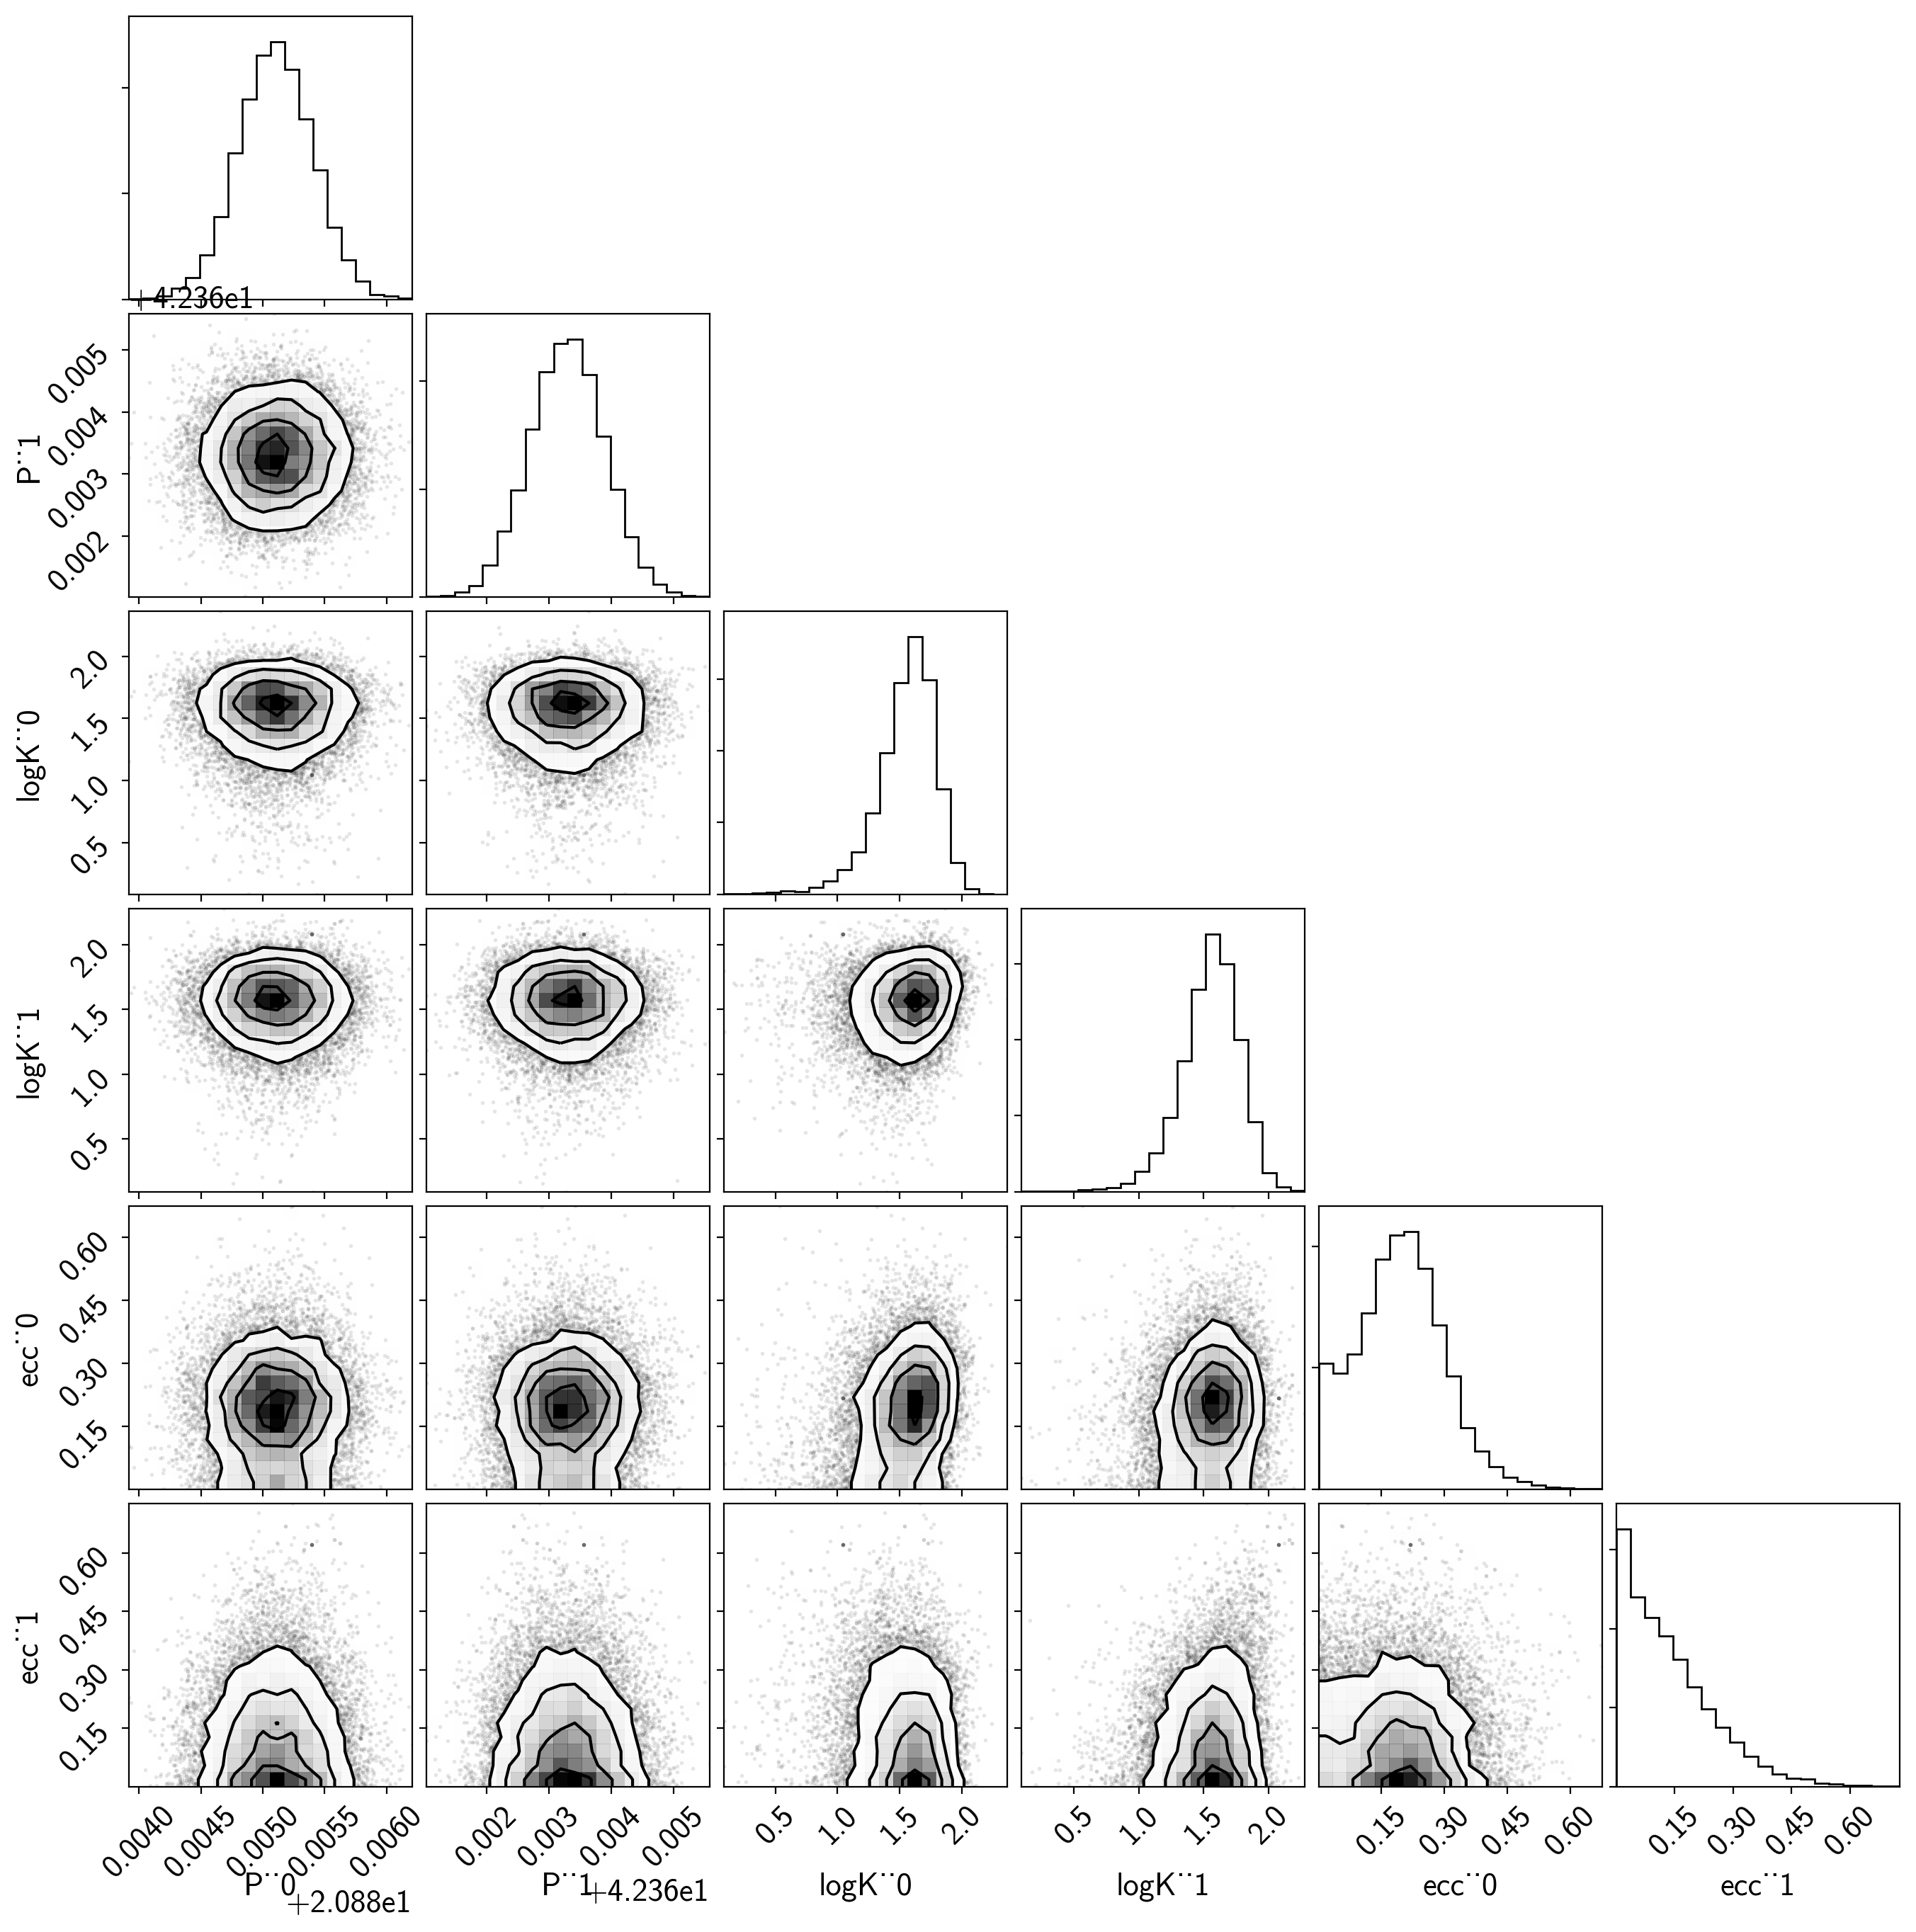

In [13]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

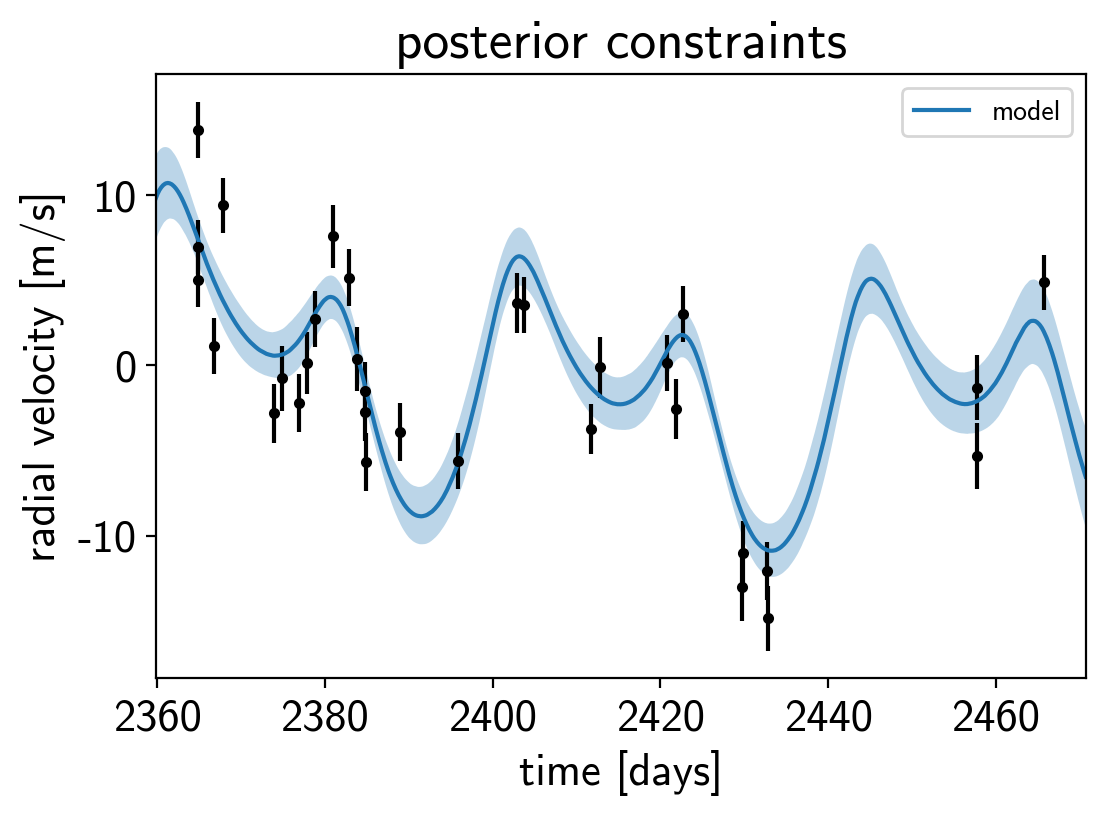

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

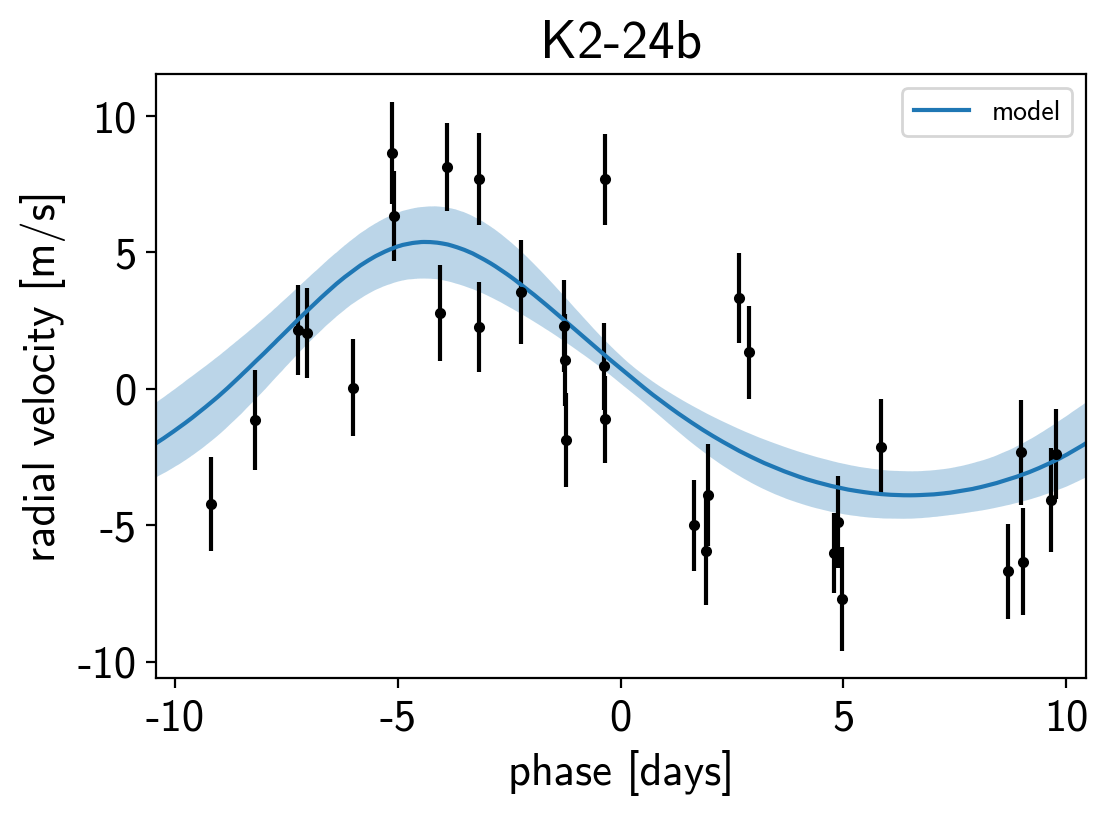

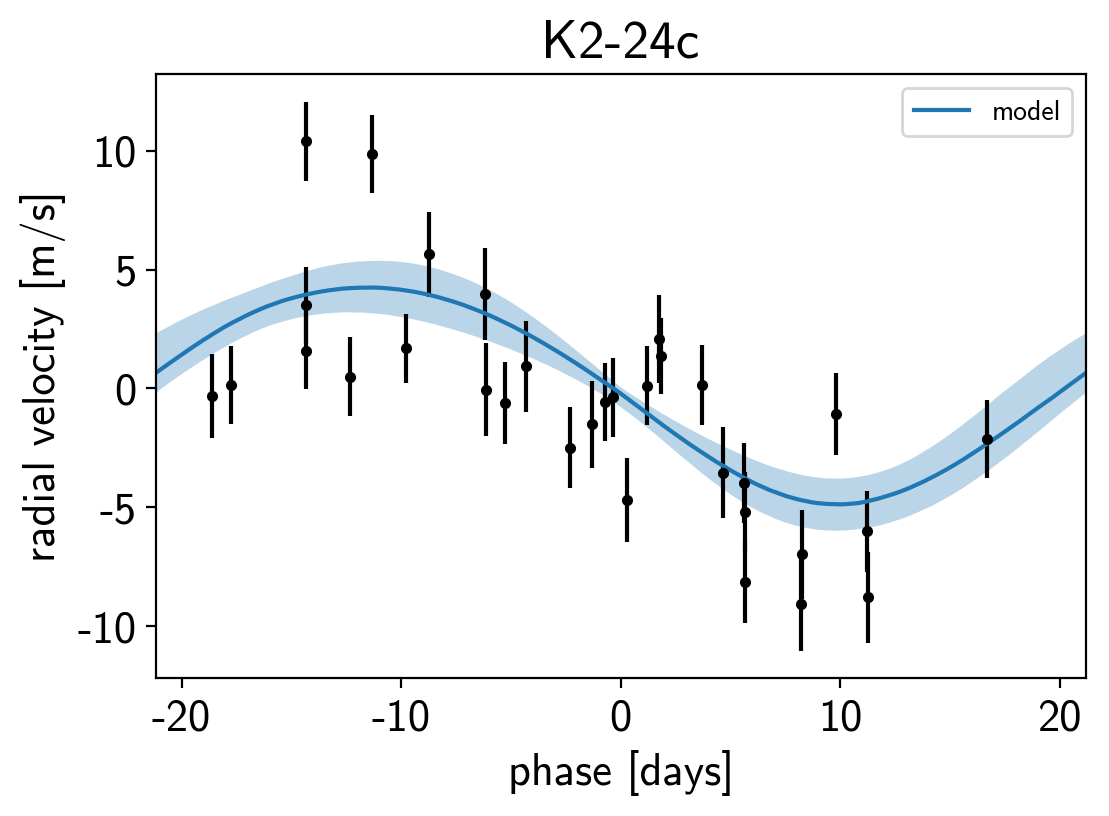

In [15]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [16]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [17]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
